## Application of count models on Movielens

In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
from collections import deque
import numpy as np
import pandas as pd
from subprocess import call
from pybpr import *
import pybpr
import matplotlib.pyplot as plt
from functools import partial


In [3]:
print(os.getcwd())


/home/ctripp/zazzle/pybpr/examples


In [4]:
# %%time
# df = load_movielens_data('ml-1m')
df = pybpr.load_movielens_data("ml-100k")
df.sort_values(["timestamp", "user_id"], inplace=True)
df.reset_index(inplace=True)
df["positive"] = (df["rating"] >= 4).astype(np.int8)
df.head()


,index,user_id,item_id,rating,timestamp,positive
0,214,259,255,4,874724710,1
1,83965,259,286,4,874724727,1
2,43027,259,298,4,874724754,1
3,21396,259,185,4,874724781,1
4,82655,259,173,4,874724843,1


In [5]:
df[df["positive"] == 0].head()


,index,user_id,item_id,rating,timestamp,positive
7,26399,259,288,3,874724905,0
11,4029,259,405,3,874725120,0
12,76434,259,1074,3,874725264,0
16,97222,851,687,2,874728168,0
17,69246,851,696,3,874728338,0


In [6]:
# %%time
test_proportion = 0.2

total = len(df)
slice_index = int(test_proportion * total)
print(f"{total} total entries. {test_proportion*100}% = {slice_index}")

# train_df = df.iloc[:slice_index].sort_values(['user_id', 'timestamp']).reset_index()
# test_df = df.iloc[slice_index:].sort_values(['user_id', 'timestamp']).reset_index()
train_df = df.iloc[:slice_index]
test_df = df.iloc[slice_index:]
test_timestamp = test_df["timestamp"].iloc[0]
print(f"test_timestamp: {test_timestamp}")


100000 total entries. 20.0% = 20000
test_timestamp: 878963305


In [7]:
test_df[test_df["positive"] == 1].head()


,index,user_id,item_id,rating,timestamp,positive
20022,96941,181,280,4,878963381,1
20023,24271,181,974,4,878963417,1
20042,11930,267,475,5,878970368,1
20043,9176,267,250,5,878970399,1
20044,45928,267,100,5,878970427,1


In [8]:
from count_model.link_counter import LinkCounter
from count_model.uniform_prior_model import UniformPriorModel
from count_model.window_counter import WindowCounter
from count_model.permutation_counter import PermutationCounter
from count_model.link_count_data import LinkCountData

positive_counter = PermutationCounter(LinkCounter())
negative_counter = PermutationCounter(LinkCounter())
both_counter = PermutationCounter(LinkCounter())
dest_counter = LinkCounter()
# counter = WindowCounter(LinkCounter(), 10)


In [9]:
def make_action_tuple(row, positive=None):
    return int(row["item_id"]), (
        bool(row["positive"] == 1) if positive is None else positive
    )


def make_item_sequence(df):
    return (row["item_id"] for row_index, row in df.iterrows())


def make_action_sequence(df):
    return (make_action_tuple(row, None) for row_index, row in df.iterrows())


In [10]:
user_groups = df.groupby("user_id")
for user_id, group in user_groups:
    user_df = user_groups.get_group(user_id)
    # positive_interactions = user_df[user_df['positive'] >= 1]
    for idx, row in user_df.iterrows():
        dest_counter.observe_link(make_action_tuple(row, False), make_action_tuple(row))
    positive_counter.observe_sequence(
        make_action_sequence(user_df[user_df["positive"] == 1])
    )
    negative_counter.observe_sequence(
        make_action_sequence(user_df[user_df["positive"] == 0])
    )
    both_counter.observe_sequence(make_action_sequence(user_df))


In [11]:
# probability_model = UniformPriorModel(counter.link_counter, 1.1, 1e5)


In [33]:
def make_pos_neg_action(action):
    return (action[0], False), (action[0], True)


def make_opposite_action(action):
    return (action[0], not action[1])


def compute_with_links(
    func,
    dest_counter,
    link_counter,
    sources,
    dest,
):
    negative_dest, positive_dest = make_pos_neg_action(dest)

    dest_count = dest_counter.get_link_count(negative_dest, positive_dest)

    source_counts = []
    for source in sources:
        opp_source = make_opposite_action(source)

        source_counts.append((
            link_counter.get_link_count(source, positive_dest),
            link_counter.get_link_count(source, negative_dest),
            link_counter.get_link_count(opp_source, positive_dest),
            link_counter.get_link_count(opp_source, negative_dest),
        ))

    p = func(LinkCountData(dest_count.count, dest_count.total), source_counts)
    if not dest[1]:
        p = 1.0 - p
    return np.log(p)


def make_score_function(prob_func, dest_counter, link_counter):
    return lambda sources, dest: compute_with_links(
        prob_func,
        dest_counter,
        link_counter,
        sources,
        dest,
    )


In [50]:
def compute_naive_bayes_posterior(
    dest_counter,
    link_counter,
    prior_numerator,
    prior_denominator,
    feature_prior_numerator,
    feature_prior_denominator,
):
    def compute(
        dest_count,
        source_counts,
    ):
        dest_prior = (prior_numerator + dest_count.count) / (prior_denominator + dest_count.total)
        pos_acc = np.log(dest_prior)
        neg_acc = np.log(1.0 - dest_prior)
        for source_count in source_counts:
            source_to_pos_dest, source_to_neg_dest, neg_source_to_pos_dest, neg_source_to_neg_dest = source_count
            # P(source | dest) -> # source to dest / (# total both source to dest)
            #  link_count(source, dest) / get_source_data(dest).total
            cond_prob = (feature_prior_numerator + source_to_pos_dest.count) / (
                feature_prior_denominator + source_to_pos_dest.count + neg_source_to_pos_dest.count)
            pos_acc += np.log(cond_prob)

            # source to -dest / total +/- source to -dest
            neg_cond_prob = (feature_prior_numerator + source_to_neg_dest.count) / (
                feature_prior_denominator + source_to_neg_dest.count + neg_source_to_neg_dest.count)
            neg_acc += np.log(neg_cond_prob)
            # evidence = (feature_prior_numerator source_count.source_count.count / source_count.source_count.total)
            # ep += dest_prior * cond_prob
            # s = source_count.source_count
            # ep += np.log((s.count + feature_prior_numerator) / (feature_prior_denominator + s.total))
        pos = np.exp(pos_acc)
        neg = np.exp(neg_acc)
        p = pos / (pos + neg)
        # print(f'{p} {pos} {neg}')
        return max(1e-12, min(1.0, p))

    return make_score_function(compute, dest_counter, link_counter)


In [37]:
def compute_max_posterior(
    dest_counter,
    link_counter,
    prior_numerator,
    prior_denominator,
    feature_prior_numerator,
    feature_prior_denomenator,
):
    def compute(
        dest_count,
        source_counts,
    ):
        p = (prior_numerator + dest_count.count) / (
            prior_denominator + dest_count.total
        )
        for source_to_pos_dest, source_to_neg_dest, neg_source_to_pos_dest, neg_source_to_neg_dest in source_counts:
            fp = (feature_prior_numerator + source_to_pos_dest.count) / (
                feature_prior_denomenator + source_to_pos_dest.count + source_to_neg_dest.count
            )
            p = max(p, fp)
        return p

    return make_score_function(compute, dest_counter, link_counter)


In [38]:
def compute_avg_posterior(
    dest_counter,
    link_counter,
    prior_numerator,
    prior_denominator,
    feature_prior_numerator,
    feature_prior_denomenator,
):
    def compute(
        dest_count,
        source_counts,
    ):
        p = (prior_numerator + dest_count.count) / (
            prior_denominator + dest_count.total
        )
        n = 1
        for source_to_pos_dest, source_to_neg_dest, neg_source_to_pos_dest, neg_source_to_neg_dest in source_counts:
            fp = (feature_prior_numerator + source_to_pos_dest.count) / (
                feature_prior_denomenator + source_to_pos_dest.count + source_to_neg_dest.count
            )
            p += fp
            n += 1
        return p / n

    return make_score_function(compute, dest_counter, link_counter)


In [39]:
def compute_combined_posterior(
    dest_counter,
    link_counter,
    prior_numerator,
    prior_denominator,
):
    def compute(
        dest_count,
        source_counts,
    ):
        numerator = prior_numerator + dest_count.count
        denominator = prior_denominator + dest_count.total
        for source_to_pos_dest, source_to_neg_dest, neg_source_to_pos_dest, neg_source_to_neg_dest in source_counts:
            numerator += source_to_pos_dest.count
            denominator += source_to_pos_dest.count + source_to_neg_dest.count
        return numerator / denominator

    return make_score_function(compute, dest_counter, link_counter)


In [40]:
def compute_bayes_posterior(
    dest_counter,
    link_counter,
    prior_numerator,
    prior_denominator,
):
    def compute(
        dest_count,
        source_counts,
    ):
        numerator = prior_numerator + dest_count.count
        denominator = prior_denominator + dest_count.total
        return numerator / denominator

    return make_score_function(compute, dest_counter, link_counter)


In [41]:
def compute_score(
    df,
    test_df,
    scoring_function,
):
    score = 0.0
    pos_score = 0.0
    neg_score = 0.0

    num_pos = 0
    user_groups = df.groupby("user_id")
    num_samples = len(test_df)
    for action_index, test_action in test_df.iterrows():
        conditioning_actions = df[df["user_id"] == test_action["user_id"]]
        conditioning_actions = conditioning_actions[
            conditioning_actions["timestamp"] < test_action["timestamp"]
        ]

        test_action_tuple = make_action_tuple(test_action)
        is_positive = test_action_tuple[1]

        element_score = scoring_function(
            make_action_sequence(conditioning_actions),
            test_action_tuple,
        )
        score += element_score

        if is_positive:
            num_pos += 1
            pos_score += element_score
        else:
            neg_score += element_score

    score /= num_samples
    if num_pos > 0:
        pos_score /= num_pos
    if num_samples > num_pos:
        neg_score /= num_samples - num_pos
    return score, pos_score, neg_score


In [42]:
test_df_sample = test_df.sample(1000)
print(len(test_df_sample))
pos_df = df[df["positive"] == 1]
pos_test_df = test_df_sample[test_df_sample["positive"] == 1]

neg_df = df[df["positive"] == 0]
neg_test_df = test_df_sample[test_df_sample["positive"] == 0]


1000


In [43]:
pos_bayes = len(train_df[train_df["positive"] == 1]) / len(train_df)
print(pos_bayes)


0.55975


In [53]:
nb_scores = compute_score(
    df,
    test_df_sample,
    compute_naive_bayes_posterior(
        dest_counter,
        both_counter.link_counter,
        pos_bayes * 10,
        10,
        1e-1,
        2e-1,
    ),
)

print(nb_scores)


(-0.38289998491649235, -0.40686770521729776, -0.35099889332730777)


In [62]:
nb_scores = compute_score(
    df,
    test_df_sample,
    compute_naive_bayes_posterior(
        dest_counter,
        both_counter.link_counter,
        pos_bayes * 10,
        10,
        1e-4,
        2e-4,
    ),
)

print(nb_scores)


(-0.2860496369676836, -0.28469470757693166, -0.2878530511451177)


In [45]:
max_scores = compute_score(
    df,
    test_df_sample,
    compute_max_posterior(
        dest_counter,
        both_counter.link_counter,
        pos_bayes * 10,
        10,
        pos_bayes * 10,
        10,
    ),
)

print(max_scores)


(-0.6394886213855521, -0.2811332869483238, -1.1164604068486228)


In [46]:
avg_scores = compute_score(
    df,
    test_df_sample,
    compute_avg_posterior(
        dest_counter,
        both_counter.link_counter,
        pos_bayes * 10,
        10,
        pos_bayes * 10,
        10,
    ),
)

print(avg_scores)


(-0.5917725626956546, -0.4903787865340702, -0.7267279151158518)


In [47]:
combined_scores = compute_score(
    df,
    test_df_sample,
    compute_combined_posterior(
        dest_counter,
        both_counter.link_counter,
        pos_bayes * 10,
        10,
    ),
)

print(combined_scores)


(-0.5585496362184379, -0.47524863660728567, -0.6694234608757087)


In [48]:
bayes_scores = compute_score(
    df,
    test_df_sample,
    compute_bayes_posterior(
        dest_counter,
        both_counter.link_counter,
        pos_bayes * 10,
        10,
    ),
)

print(bayes_scores)


(-0.6088252065135693, -0.5046516503291835, -0.7474804526237897)


In [49]:
nb_pos_scores = compute_score(
    pos_df,
    pos_test_df,
    make_compute_nb(
        dest_counter,
        positive_counter.link_counter,
        5,
        1,
        10,
    ),
)

print(nb_pos_scores)


NameError: name 'make_compute_nb' is not defined

In [227]:
max_pos_scores = compute_score(
    pos_df,
    pos_test_df,
    make_compute_mp(
        dest_counter,
        positive_counter.link_counter,
        5,
        10,
        5,
        10,
    ),
)

print(max_pos_scores)


(-0.519822756521293, -0.519822756521293, 0.0)


In [219]:
nb_neg_scores = compute_score(
    neg_df,
    neg_test_df,
    make_compute_nb(
        dest_counter,
        negative_counter.link_counter,
        5,
        1,
        10,
    ),
)

print(nb_pos_scores)


(-100.06263639311518, -100.06263639311518, 0.0)


In [193]:
def compute_scores(
    df,
    test_timestamp,
    num_samples,
):
    max_log_score = 0.0
    max_log_pos_score = 0.0
    max_log_neg_score = 0.0
    max_log_pos_only_score = 0.0
    max_log_neg_only_score = 0.0

    log_score = 0.0
    pos_only_score = 0.0
    pos_score = 0.0
    neg_only_score = 0.0
    neg_score = 0.0

    prior_numerator = 5
    interaction_prior_numerator = 1
    prior_denominator = 10

    num_pos = 0
    user_groups = df.groupby("user_id")
    for action_index, test_action in (
        df[df["timestamp"] >= test_timestamp].sample(num_samples).iterrows()
    ):
        conditioning_actions = df[df["user_id"] == test_action["user_id"]]
        conditioning_actions = conditioning_actions[
            conditioning_actions["timestamp"] < test_action["timestamp"]
        ]

        is_positive = test_action["positive"] == 1

        test_action_tuple = make_action_tuple(test_action)

        posterior = compute_naive_bayes_posterior(
            dest_counter,
            both_counter.link_counter,
            prior_numerator,
            interaction_prior_numerator,
            prior_denominator,
            make_action_sequence(conditioning_actions),
            test_action_tuple,
        )
        log_score += posterior

        max_posterior = compute_max_posterior(
            dest_counter,
            both_counter.link_counter,
            prior_numerator,
            prior_denominator,
            prior_numerator,
            prior_denominator,
            make_action_sequence(conditioning_actions),
            test_action_tuple,
        )
        max_log_score += max_posterior

        if is_positive:
            num_pos += 1
            pos_score += posterior
            max_log_pos_score += max_posterior
            pos_posterior = compute_naive_bayes_posterior(
                dest_counter,
                positive_counter.link_counter,
                prior_numerator,
                interaction_prior_numerator,
                prior_denominator,
                make_action_sequence(
                    conditioning_actions[conditioning_actions["positive"] == 1]
                ),
                test_action_tuple,
            )
            pos_only_score += pos_posterior
        else:
            neg_score += posterior
            max_log_neg_score += max_posterior
            neg_posterior = compute_naive_bayes_posterior(
                dest_counter,
                negative_counter.link_counter,
                prior_numerator,
                interaction_prior_numerator,
                prior_denominator,
                make_action_sequence(
                    conditioning_actions[conditioning_actions["positive"] == 0]
                ),
                test_action_tuple,
            )
            neg_only_score += neg_posterior

    num_neg = num_samples - num_pos
    return (
        log_score / num_samples,
        max_log_score / num_samples,
        pos_only_score / num_pos,
        pos_score / num_pos,
        max_log_pos_score / num_pos,
        neg_only_score / num_neg,
        neg_score / num_neg,
        max_log_neg_score / num_neg,
    )


In [194]:
(
    log_score,
    max_log_score,
    pos_only_score,
    pos_score,
    max_log_pos_score,
    neg_only_score,
    neg_score,
    max_log_neg_score,
) = compute_scores(df, test_timestamp, 1000)
print(
    log_score,
    max_log_score,
    pos_only_score,
    pos_score,
    max_log_pos_score,
    neg_only_score,
    neg_score,
    max_log_neg_score,
)
print(pos_only_score / pos_score)


-193.5066106819812 -0.591965420253416 -87.8531166153852 -160.99039073805392 -0.4903192721564039 -129.19700692314512 -232.14185669850804 -0.7127397275109146
0.545704102043769


In [110]:
log_score, pos_only_score, pos_score, neg_only_score, neg_score = compute_scores(
    df, 0, 1000
)
print(log_score, pos_only_score, pos_score, neg_only_score, neg_score)
print(pos_only_score / pos_score)


-906.7507792407138 -450.96249475957217 -759.5979154703118 -581.1934268825369 -1075.376593089203
0.5936857982033228


In [9]:
ndcg_score


0.45679663853798047

## Effect of num of features on ndcg

In [15]:
num_features_list = np.arange(1, 100, 4)
ndcg_list = []
for num_features in num_features_list:
    print(num_features, end="-", flush=True)
    als = MF_ALS(
        num_features=num_features,
        reg_lambda=0.0,
        num_iters=10,
        initial_std=0.1,
        seed=None,
    )
    als.fit(cf.R_train)
    als_ndcg_func = partial(
        cf.get_ndcg_metric, user_mat=als.user_mat, item_mat=als.item_mat, num_items=10
    )
    svd = MF_SVD(num_features=num_features, num_iters=100, seed=None)
    svd.fit(cf.R_train)
    svd_ndcg_func = partial(
        cf.get_ndcg_metric, user_mat=svd.user_mat, item_mat=svd.item_mat, num_items=10
    )
    result_dict = {
        "num_features": num_features,
        "als_test": als_ndcg_func(test=True),
        "als_train": als_ndcg_func(test=False),
        "svd_test": svd_ndcg_func(test=True),
        "svd_train": svd_ndcg_func(test=False),
    }
    ndcg_list.append(result_dict)
ndcg_df = pd.DataFrame(ndcg_list)


1-5-9-13-17-21-25-29-33-37-41-45-49-53-57-61-65-69-73-77-81-85-89-93-97-

In [16]:
ndcg_df.head()


,num_features,als_test,als_train,svd_test,svd_train
0,1,0.269689,0.458040,0.269689,0.458040
1,5,0.410831,0.658544,0.409970,0.658617
2,9,0.448681,0.716662,0.451182,0.717836
3,13,0.460963,0.757014,0.462949,0.753311
4,17,0.462086,0.793263,0.462804,0.797053


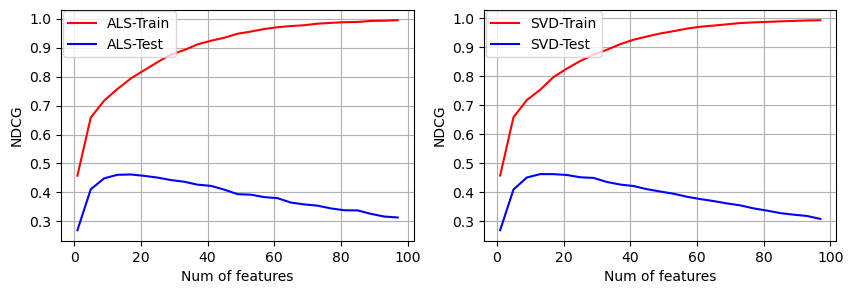

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(ndcg_df["num_features"], ndcg_df["als_train"], "-r", label="ALS-Train")
ax[0].plot(ndcg_df["num_features"], ndcg_df["als_test"], "-b", label="ALS-Test")
ax[1].plot(ndcg_df["num_features"], ndcg_df["svd_train"], "-r", label="SVD-Train")
ax[1].plot(ndcg_df["num_features"], ndcg_df["svd_test"], "-b", label="SVD-Test")
for iax in ax:
    iax.grid(True)
    # iax.set_ylim([0, 1])
    iax.set_ylabel("NDCG")
    iax.set_xlabel("Num of features")
    iax.legend(loc=2, borderaxespad=0.1)


## Conclusions
- Around 10-20 features seems to provide best NDCG for Movielens-100k data
- ALS and SVD have same solution when using no regularization on ALS cost function
- Changing the num_items when computing NDCG just scales the NDCG-num_of_features relation
- Adding reularization to ALS makes sure it does not overfit for large num of features
- ALS with regularization has the same optimal NDCG and num of features as SVD
- ALS solution seems to converging at around 10 iterations